In [1]:
import os
import re
import logging
import pandas as pd
import numpy as np
import pdfplumber
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [3]:
def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in {'pdf'}

In [4]:
def extract_csv_from_pdf(pdf_path):
    try:
        with pdfplumber.open(pdf_path) as pdf:
            all_text = ""
            for page in pdf.pages:
                all_text += page.extract_text()

        lines = re.split(r'\r?\n|\r', all_text)
        lines = [line.strip() for line in lines if line.strip()]

        column_names = ['Year', 'Company', 'Market_Cap_in_B_USD', 'Revenue', 'Gross_Profit', 
                        'Net_Income', 'Cash_Flow_from_Operating', 'Cash_Flow_from_Investing', 
                        'Cash_Flow_from_Financial_Activities', 'Debt_Equity_Ratio']
        
        data_lines = [line.split(',') for line in lines]
        final_data = []
        
        for line in data_lines:
            cleaned_line = [element.strip() for element in line]
            if len(cleaned_line) < len(column_names):
                cleaned_line += [''] * (len(column_names) - len(cleaned_line))
            final_data.append(cleaned_line)

        df = pd.DataFrame(final_data, columns=column_names)
        for col in column_names[0:1] + column_names[2:]:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        df = df.dropna(thresh=len(df.columns) // 2)
        return df

    except Exception as e:
        logging.error(f"PDF processing error: {str(e)}")
        raise ValueError(f"An error occurred during PDF processing: {str(e)}")


In [5]:
class AgenticAI:
    def __init__(self):
        self.models = {}

    def initialize_models(self):
        self.models['IsolationForest'] = IsolationForest(contamination=0.1, random_state=42)
        self.models['KMeans'] = KMeans(n_clusters=2, random_state=42)
        self.models['PCA'] = PCA(n_components=2)
        self.models['Autoencoder'] = MLPRegressor(hidden_layer_sizes=(128, 64, 128), max_iter=200, random_state=42)

    def preprocess_data(self, data):
        features = data[['Revenue', 'Net_Income', 'Debt_Equity_Ratio']]
        imputer = SimpleImputer(strategy='mean')
        features_imputed = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)
        return features_imputed

    def detect_anomalies(self, data, features_imputed):
        data['IsolationForest'] = self.models['IsolationForest'].fit_predict(features_imputed)
        data['KMeans'] = self.models['KMeans'].fit_predict(features_imputed)

        reduced_features = self.models['PCA'].fit_transform(features_imputed)
        data['PCA_Component_1'] = reduced_features[:, 0]
        data['PCA_Component_2'] = reduced_features[:, 1]

        self.models['Autoencoder'].fit(features_imputed, features_imputed)
        reconstructed = self.models['Autoencoder'].predict(features_imputed)
        reconstruction_error = ((features_imputed - reconstructed) ** 2).mean(axis=1)
        data['ReconstructionError'] = reconstruction_error

        threshold = reconstruction_error.mean() + 1.5 * reconstruction_error.std()
        data['Autoencoder'] = (reconstruction_error > threshold).astype(int)

        return data

    def proactive_suggestions(self, data):
        suggestions = []
        anomalies = data[data['IsolationForest'] == -1]
        for _, anomaly in anomalies.iterrows():
            suggestions.append(f"High-risk company detected: Year={anomaly['Year']}, Revenue={anomaly['Revenue']}")
        return suggestions

    def run(self, data):
        self.initialize_models()
        features_imputed = self.preprocess_data(data)
        processed_data = self.detect_anomalies(data.copy(), features_imputed)
        suggestions = self.proactive_suggestions(processed_data)
        return processed_data, suggestions

In [6]:
def calculate_metrics(true_labels, predictions):
    """Calculate and return evaluation metrics."""
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, zero_division=0)
    recall = recall_score(true_labels, predictions, zero_division=0)
    f1 = f1_score(true_labels, predictions, zero_division=0)
    return accuracy, precision, recall, f1


2024-12-03 09:14:38,772 - INFO - PDF data extraction completed successfully.



Evaluation Metrics:
Accuracy: 0.79
Precision: 0.00
Recall: 0.00
F1-Score: 0.00


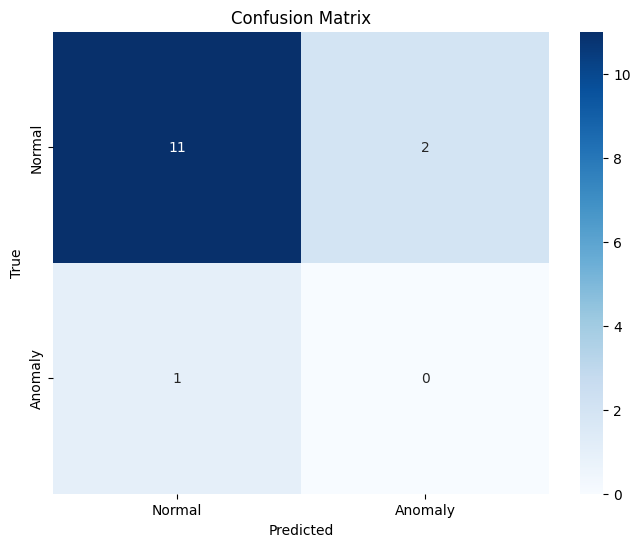


Proactive Suggestions:
High-risk company detected: Year=2022.0, Revenue=394328.0
High-risk company detected: Year=2010.0, Revenue=65225.0


In [7]:
pdf_path = 'financialstatement.pdf'
try:
    data = extract_csv_from_pdf(pdf_path)
    logging.info("PDF data extraction completed successfully.")
    anomaly_indices = np.random.choice(data.index, size=int(len(data) * 0.1), replace=False)
    data['True_Anomaly'] = 0
    data.loc[anomaly_indices, 'True_Anomaly'] = 1
    agent = AgenticAI()
    processed_data, suggestions = agent.run(data)
    true_labels = data['True_Anomaly']
    predicted_labels = (processed_data['IsolationForest'] == -1).astype(int)
    accuracy, precision, recall, f1 = calculate_metrics(true_labels, predicted_labels)
    print("\nEvaluation Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Proactive Suggestions
    print("\nProactive Suggestions:")
    for suggestion in suggestions:
        print(suggestion)

except Exception as e:
    print(f"An error occurred: {e}")


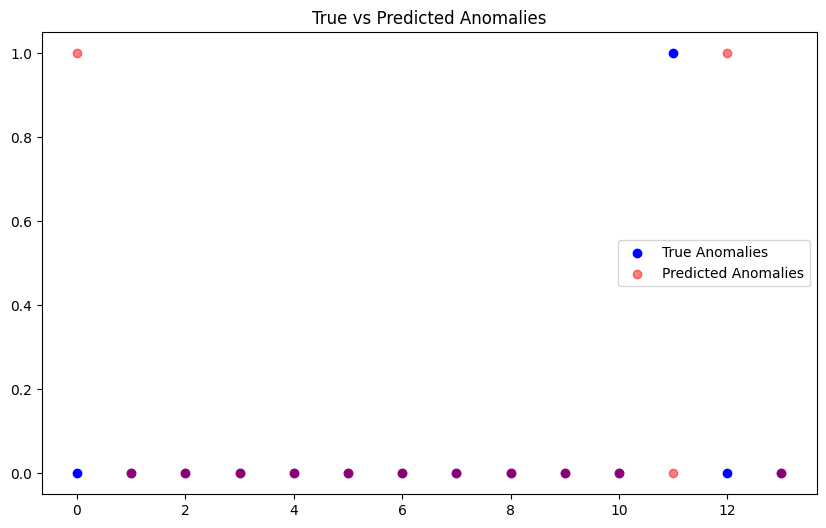

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(data)), true_labels, color='blue', label='True Anomalies')
plt.scatter(range(len(data)), predicted_labels, color='red', alpha=0.5, label='Predicted Anomalies')
plt.legend()
plt.title("True vs Predicted Anomalies")
plt.show()
